In [10]:
'''
File : joelfinal.ipynb
Description : Jupyter Notebook for ECON3203 Group Assignment
'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline

# === Load Data ===

ATM_test : pd.DataFrame = pd.read_csv("ATM_test.csv") # To keep the markers happy

raw_sample : pd.DataFrame = pd.read_csv("ATM_sample.csv")
raw_test : pd.DataFrame = ATM_test.copy()

# Section : Exploratory Data Analysis

This section will cover EDA.

1. Data summary statistics
2. Variable distributions
3. Relationships between variables
4. Insights

In [11]:
'''
Data Summary Statistics
'''

raw_sample_summary : pd.DataFrame = raw_sample.describe()

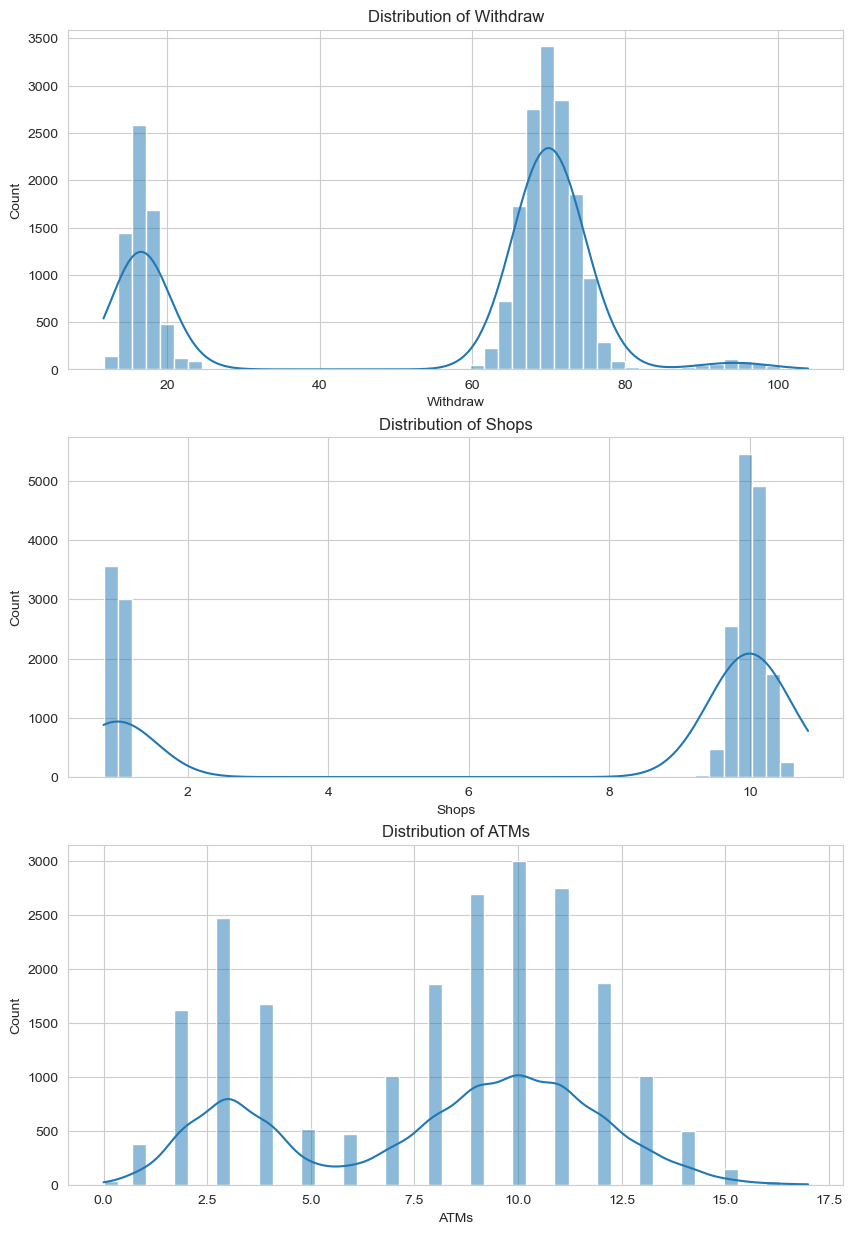

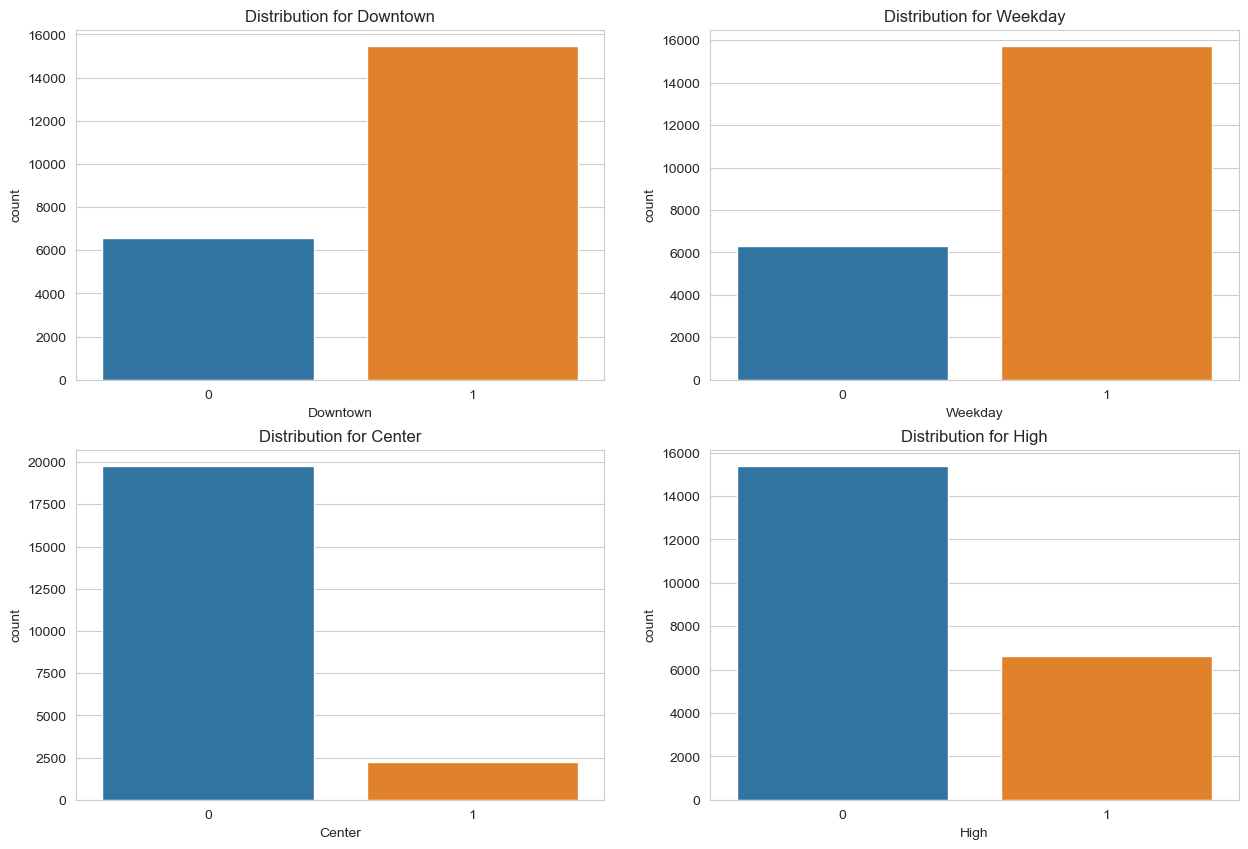

In [12]:
'''
Variable Distributions
'''

sns.set_style("whitegrid")

numerical_variables : list[str] = ["Withdraw", "Shops", "ATMs"]
categorical_variables : list[str] = ["Downtown", "Weekday", "Center", "High"]

# === Numerical Distributions ===

_, num_axes = plt.subplots(3, 1, figsize=(10, 15))

for i, var in enumerate(numerical_variables) :

    sns.histplot(raw_sample[var], bins=50, kde=True, ax=num_axes[i])
    num_axes[i].set_title(f"Distribution of {var}")


# === Categorical Distributions ===

_, c_axes = plt.subplots(2, 2, figsize=(15,10))
cat_axes = [a for sublist in c_axes for a in sublist]

for i, var in enumerate(categorical_variables) :

    sns.countplot(x=var, data=raw_sample, ax=cat_axes[i])
    cat_axes[i].set_title(f"Distribution for {var}")


plt.show()

/Users/joelmaxwell/miniconda3/envs/econ-unsw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


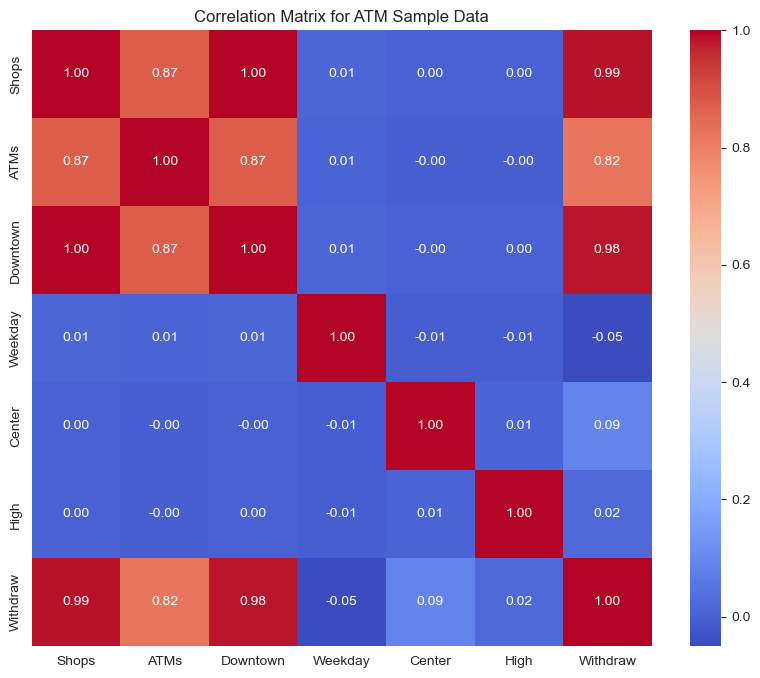

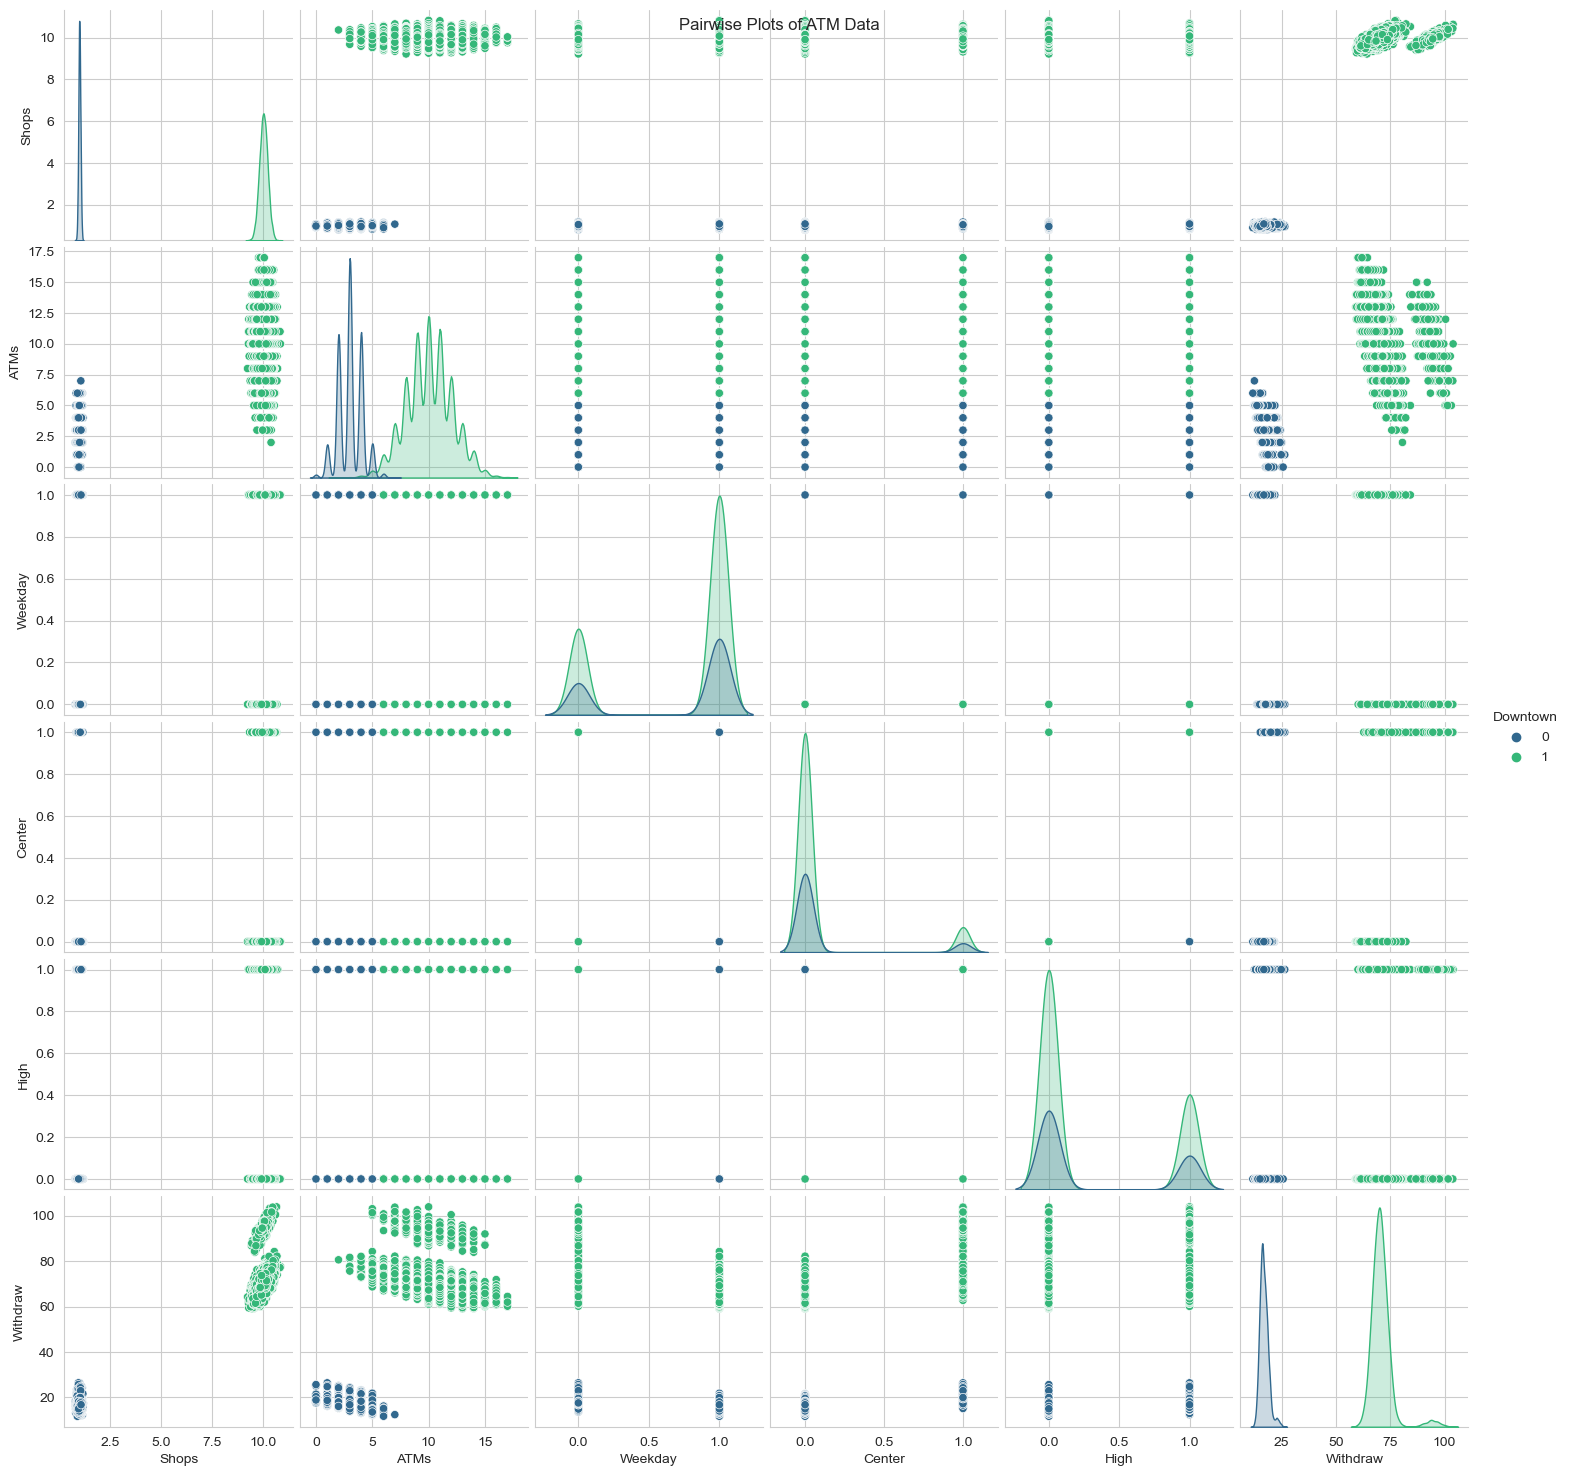

In [13]:
'''
Relationships between variables
'''

# === Correlation Matrix ===

corr_matrix : pd.DataFrame = raw_sample.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for ATM Sample Data')

# === Pairwise Plots ===

# NOTE: Since Withdrawals is highly correlated with the binary variable downtown, set the hue variable to be Downtown to search for groupings

pairwise_plot = sns.pairplot(raw_sample, kind='scatter', diag_kind='kde', hue="Downtown", palette='viridis')
pairwise_plot.fig.suptitle("Pairwise Plots of ATM Data")

plt.show()

## Insights

#### Summary Statistics

- There are 22,000 observations in the dataset with no missing values
- Shops has a mean of approximately 7.32, with a standard deviation of about 4.12
- ATMs averages around 7.94, with a standard deviation of 3.67.
- Downtown indicates that approximately 70% of the ATMs are located downtown.
- 71% of the records are from weekdays.
- 10% of the ATMs are located in a center.
- 30% of the ATMs had a high cash demand in the last month.
- Withdraw has a mean of approximately 54,653, with a standard deviation of 25,100.

Most ATMs in the dataset are located downtown and are accessed on weekdays. There is a higher density of both shops and other ATMs near the recorded ATMs. The average daily withdrawal amount is quite variable, suggesting there might be different customer behaviors or varying levels of foot traffic across these ATM locations.

#### Distribution Summary

- Shops has a bimodal distribution -> Suggesting there may be two distinct groups
- ATMs has a similar distribution to shops -> Further suggesting two distinct groups of ATMs
- More ATMs downtown than not
- Data collection is weighted towards weekdays
- Most ATMs did not have high cash demand last month
- Most ATMs are not in a center

#### Correlation Summary

- Withdraw is highly correlated with Shops, Downtown and ATMs
- Withdraw is more weakly correlated with Weekends, Center and High
- There is a high correlation between shops and downtown (Drop downtown as it has a lower correlation with Withdraw)
    > This correlation makes sense as intuitively there will be more shops downtown

#### Pairwise Summary

- Clear groupings in the data based on the downtown variable
- There also appears to be smaller groupings based on the weekday variable
- Looks to be a linear relationship between (Shops, ATMS) and Withdrawals

#### Story Behind the Data

ATMs tend to be located in downtown areas where the population is high, this corresponds to a greater number of shops and other ATMs nearby. Withdrawal amounts are higher on weekdays, which could be due to regular weekday transactions. However, the relationship between the number of nearby shops/ATMs and the withdrawal amount is not entirely linear, suggesting other factors might influence withdrawal behavior, such as the specific day of the week, events, or seasonal trends.

There might also be different clusters of ATMs. For example, those in high-density commercial areas and those in less commercial areas. These environments could cater to different customer behaviors which would be reflected by the withdrawal amount. This is made clear in the pairwise plot where the hue is based on the downtown variable. When plotting, it becomes apparent that there are two distinct groups.

#### Potential Next Steps

- Naive Linear Model : Fit a linear model to the data
- Feature Engineering : Transforming covariates could uncover non-linear behaviours
- Model Selection : Linear Regression, potentially using regularization techniques such as LASSO or Ridge to handle multicolinearity (eg. Shops and Downtown)

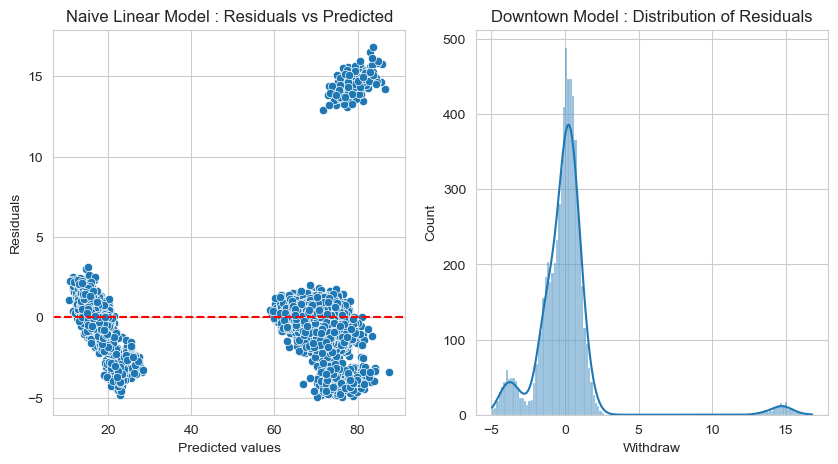

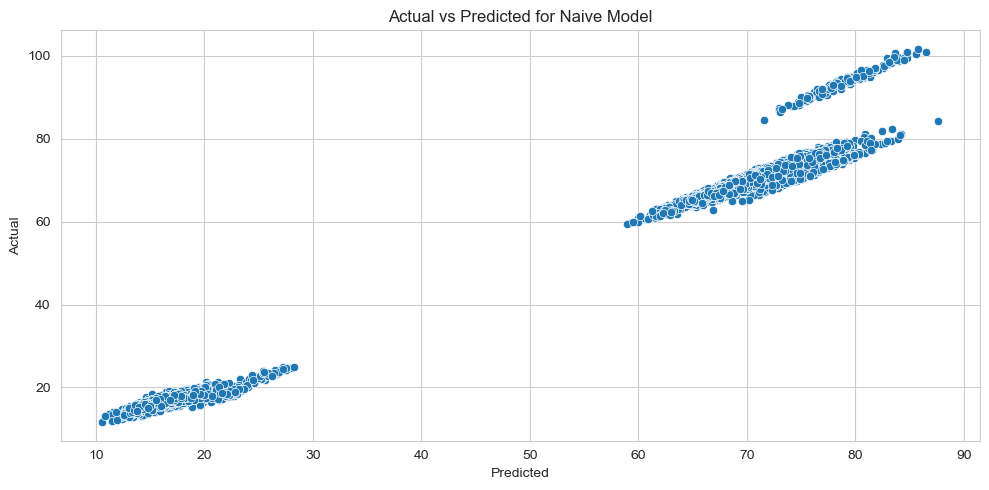

Naive MSE vs Test Sample : 7.907951014410795
Niave Model R2 Value : 0.9875430384411401


In [14]:
'''
Naive Linear Model
'''

numerical_covariates : list[str] = ["Shops", "ATMs"]

naive_linear : LinearRegression = LinearRegression()
std_scaler : StandardScaler = StandardScaler()

# === Prepare the Data ===

y_obs : pd.DataFrame = raw_sample['Withdraw']
x_obs : pd.DataFrame = raw_sample.drop('Withdraw', axis=1)

x_scaled : np.ndarray = std_scaler.fit_transform(x_obs[numerical_covariates])
x_obs[numerical_covariates] = x_scaled

X_train, X_test, Y_train, Y_test = train_test_split(x_obs, y_obs, test_size=0.3, random_state=23)


# === Train and Examine ===

naive_linear.fit(X_train, Y_train)
y_pred : np.ndarray = naive_linear.predict(X_test)
residuals : np.ndarray = Y_test - y_pred

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
axs[0].set_title('Naive Linear Model : Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title('Downtown Model : Distribution of Residuals')

_, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(x=y_pred, y=Y_test, ax=axs)

axs.set_title("Actual vs Predicted for Naive Model")
axs.set_ylabel("Actual")
axs.set_xlabel("Predicted")

plt.tight_layout()
plt.show()

y_test_sample : pd.DataFrame = raw_test['Withdraw']
x_test_sample : pd.DataFrame = raw_test.drop('Withdraw', axis=1)

x_scaled_test : np.ndarray = std_scaler.fit_transform(x_test_sample[numerical_covariates])
x_test_sample[numerical_covariates] = x_scaled_test

y_test_pred = naive_linear.predict(x_test_sample)

mse_naive : float = mean_squared_error(y_test_sample, y_test_pred)

print(f"Naive MSE vs Test Sample : {mse_naive}")
print(f"Niave Model R2 Value : {r2_score(y_test_sample, y_test_pred)}")


## Section : Model Discussion and Transformations

The above linear model simply took the data and attempted to fit a regression line to it. Whilst this model does describe some of the data, it is clear that there are obvious clusters present in the data. The residual vs predicted plot shows 3 distinct groupings, the histogram of residuals is skewed and the actual vs predicted plot also shows clear non-linear behaviour and there are obvious departures from the ideal diagonal line. 

The first step to handle this would be to deal with the bimodal distributions. It is clear from both the EDA and the Naive Regression Model that the data is bimodal, which could be what is causing this clustering. One simple transformation we can do is to split the data based on the variable downtown, which may be what is responsible for allocating observations in each peak of the withdrawal distribution. 

/var/folders/1z/xp8wfqlj6510nj44w07h7lz80000gn/T/ipykernel_62905/1239941134.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_downtown_lo.drop(columns=['Downtown'], inplace=True)
/var/folders/1z/xp8wfqlj6510nj44w07h7lz80000gn/T/ipykernel_62905/1239941134.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_downtown_hi.drop(columns=['Downtown'], inplace=True)


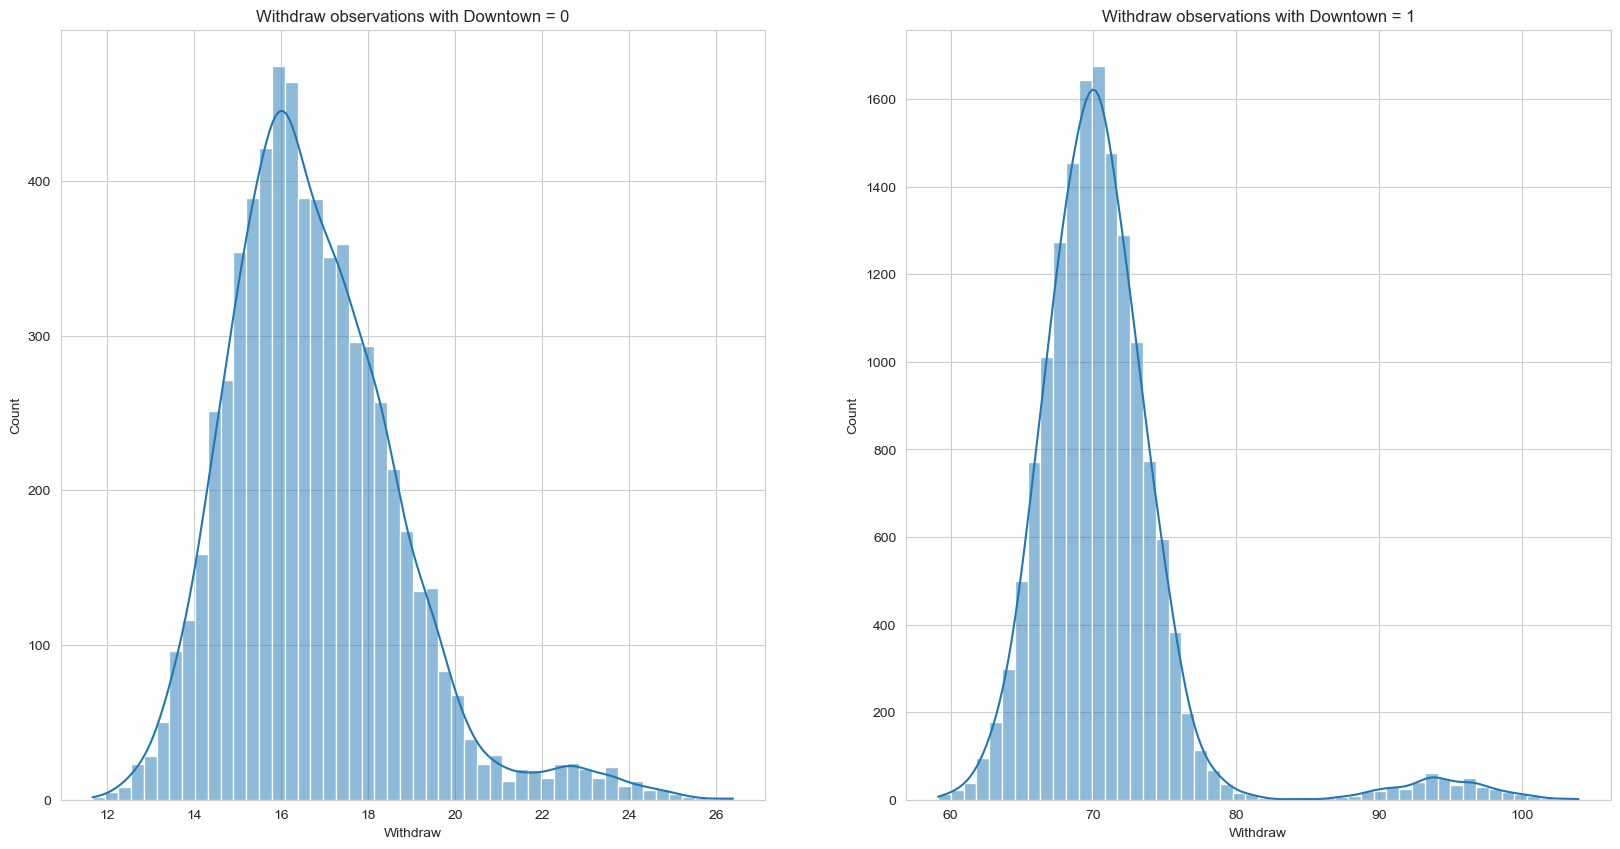

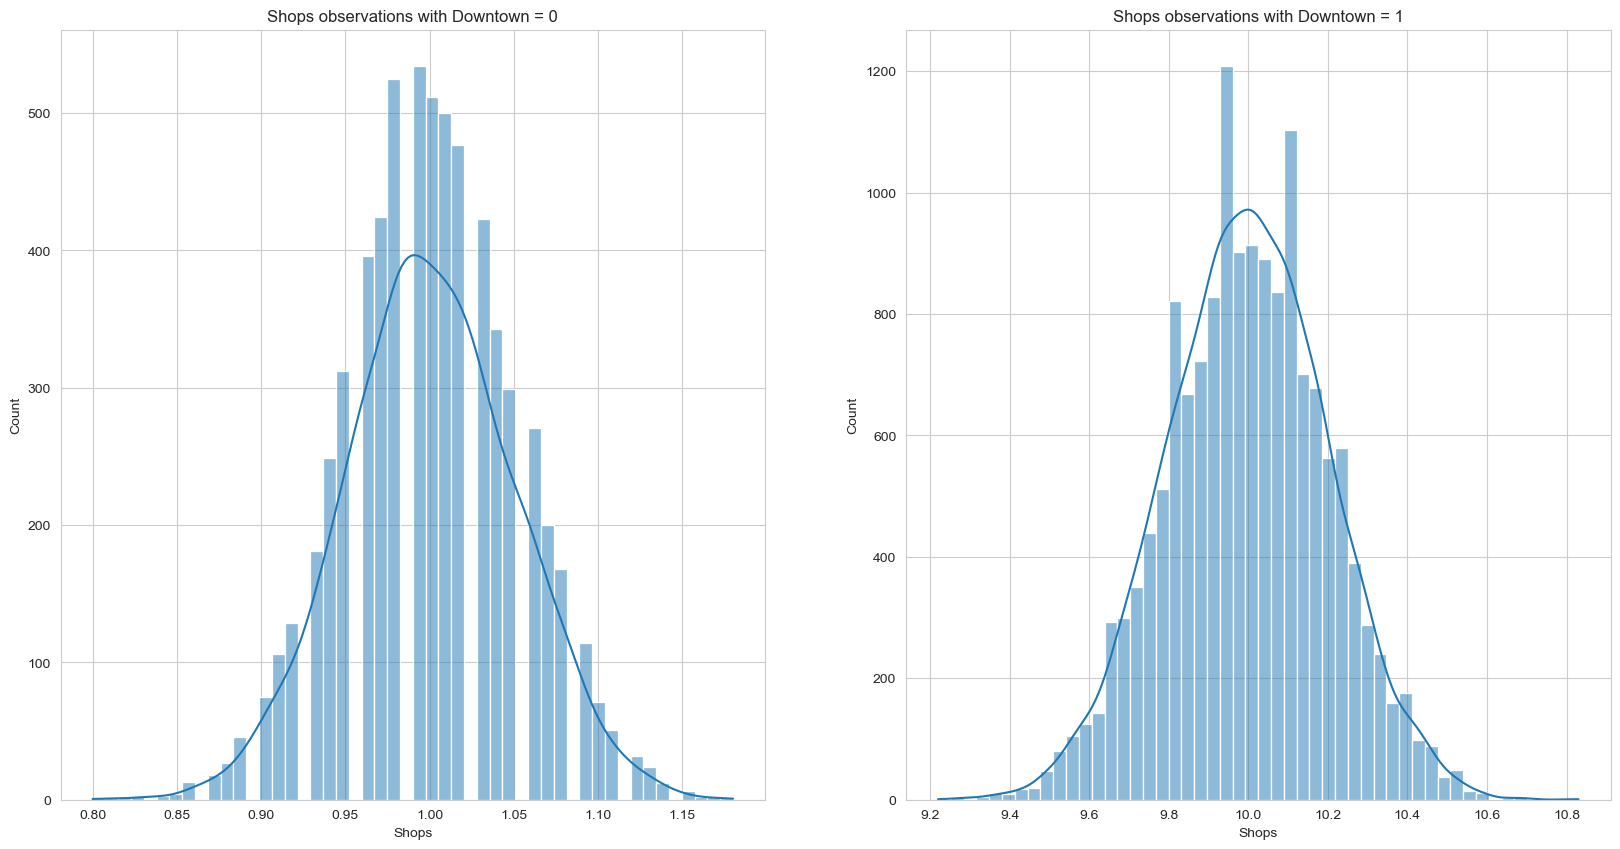

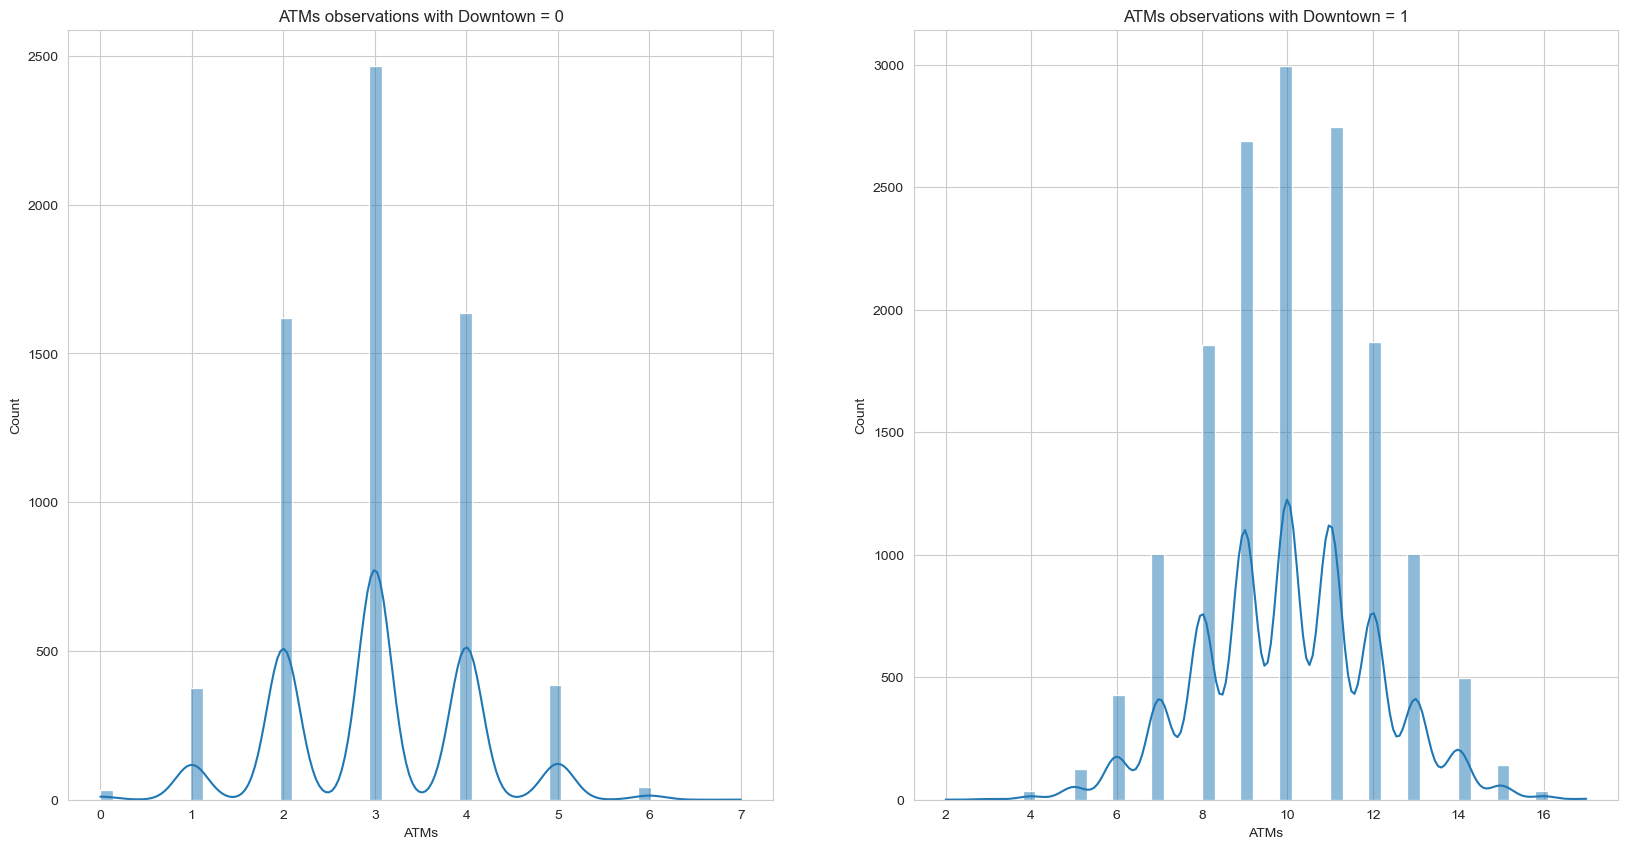

Text(0.5, 1.0, 'Correlation Matrix for Non-Downtown ATM Sample Data')

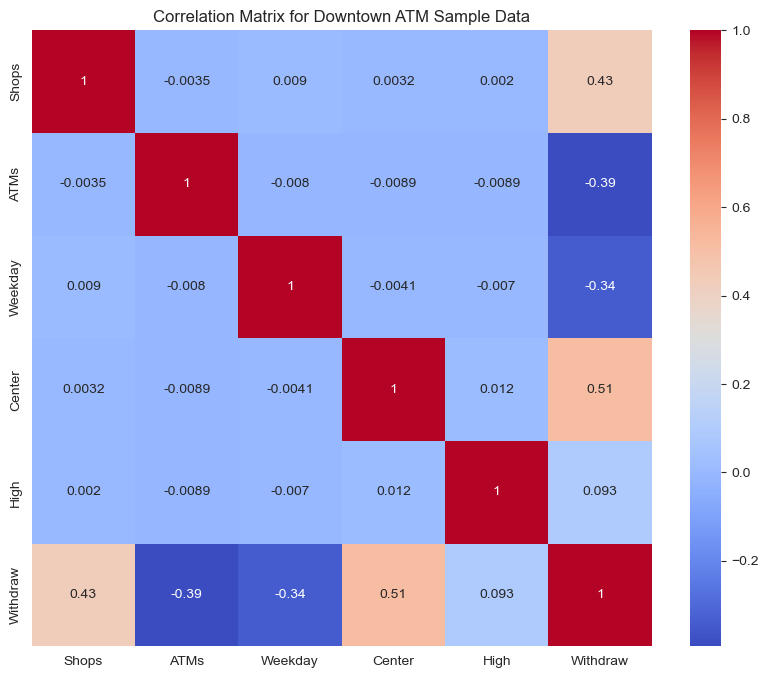

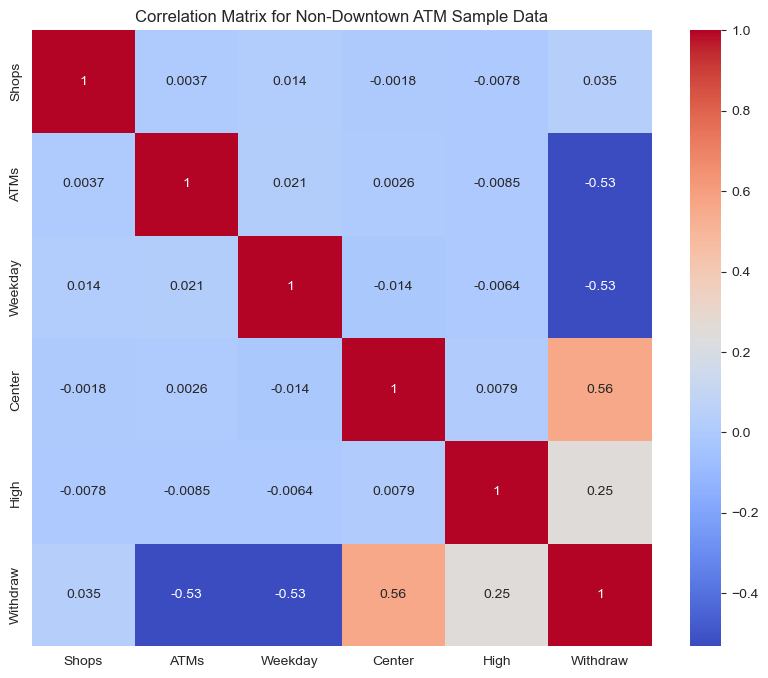

In [15]:
'''
Transformations

1. Split data based on downtown

'''

engineered_sample : pd.DataFrame = raw_sample.copy()

# Try splitting bimodal features into seperate normally distributed features by downtown

sample_downtown_lo = engineered_sample[engineered_sample['Downtown'] == 0]
sample_downtown_hi = engineered_sample[engineered_sample['Downtown'] == 1]

sample_downtown_lo.drop(columns=['Downtown'], inplace=True)
sample_downtown_hi.drop(columns=['Downtown'], inplace=True)


for bimodal in numerical_variables :

    _, [ax_lo, ax_hi] = plt.subplots(1, 2, figsize=(20, 10))

    sns.histplot(sample_downtown_lo[bimodal], bins=50, kde=True, ax=ax_lo)
    sns.histplot(sample_downtown_hi[bimodal], bins=50, kde=True, ax=ax_hi)

    ax_lo.set_title(f"{bimodal} observations with Downtown = 0")
    ax_hi.set_title(f"{bimodal} observations with Downtown = 1")

    plt.show()

# === Split Correlation Matrix ===

corr_matrix_hi : pd.DataFrame = sample_downtown_hi.corr()
corr_matrix_lo : pd.DataFrame = sample_downtown_lo.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_hi, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Downtown ATM Sample Data')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_lo, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Non-Downtown ATM Sample Data')


### Feature Engineering - Interpretation of Downtown Split

The above plots support the idea that there are two distinct groups within the data. Above we split the bimodal observations based on the downtown variable. This yielded two unimodal distributions. So to summarize, this means that there is a distinct group for downtown observations and non-downtown observations.

This is important since different groupings may exhibit different behaviours. To further investigate these differences we re-plot the correlation matrices so that we can see if there are differences in how relevant certain covariates are in each group.

Immediately we see that the Center variable is relevant in both groups, where before (in the bimodal combined set), it was not relevant. We see the variable "High" has an increased relevance for ATMs that are not downtown whilst not so much for ATMs that are downtown. Additionally, the effect of the weekday variable has been boosted in both groups by an order of magnitude in comparison to what it was before.

This analysis confirms that withdrawal behaviours could be influenced by different factors depending on the ATMs location. As such, it may be a good idea to split the data before creating our models as the covariates will contribute differently depending on where the ATM is. Alternatively it may be wise to include interaction terms. 

## Section : Standard Linear Models

Build Standard Linear Models for each group

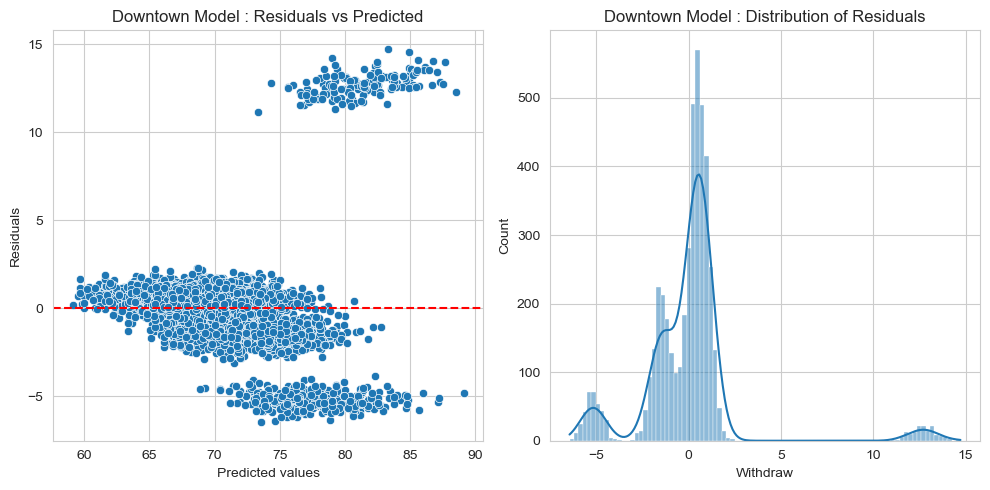

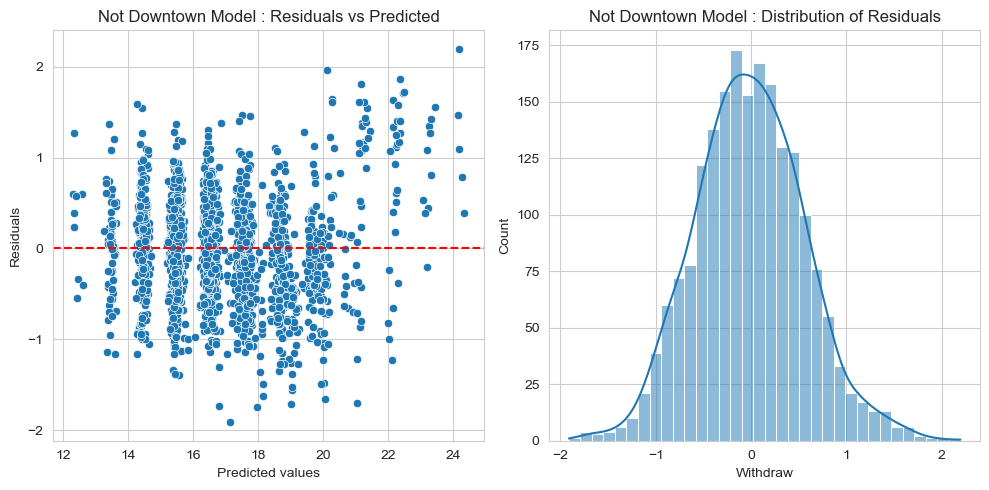

Downtown MSE vs Test Sample : 14.228415417234276
Downtown Model R2 Value : 0.7109773583426107
Not Downtown MSE vs Test Sample : 2.083370453615856
Not Downtown Model R2 Value : 0.9210420132140054


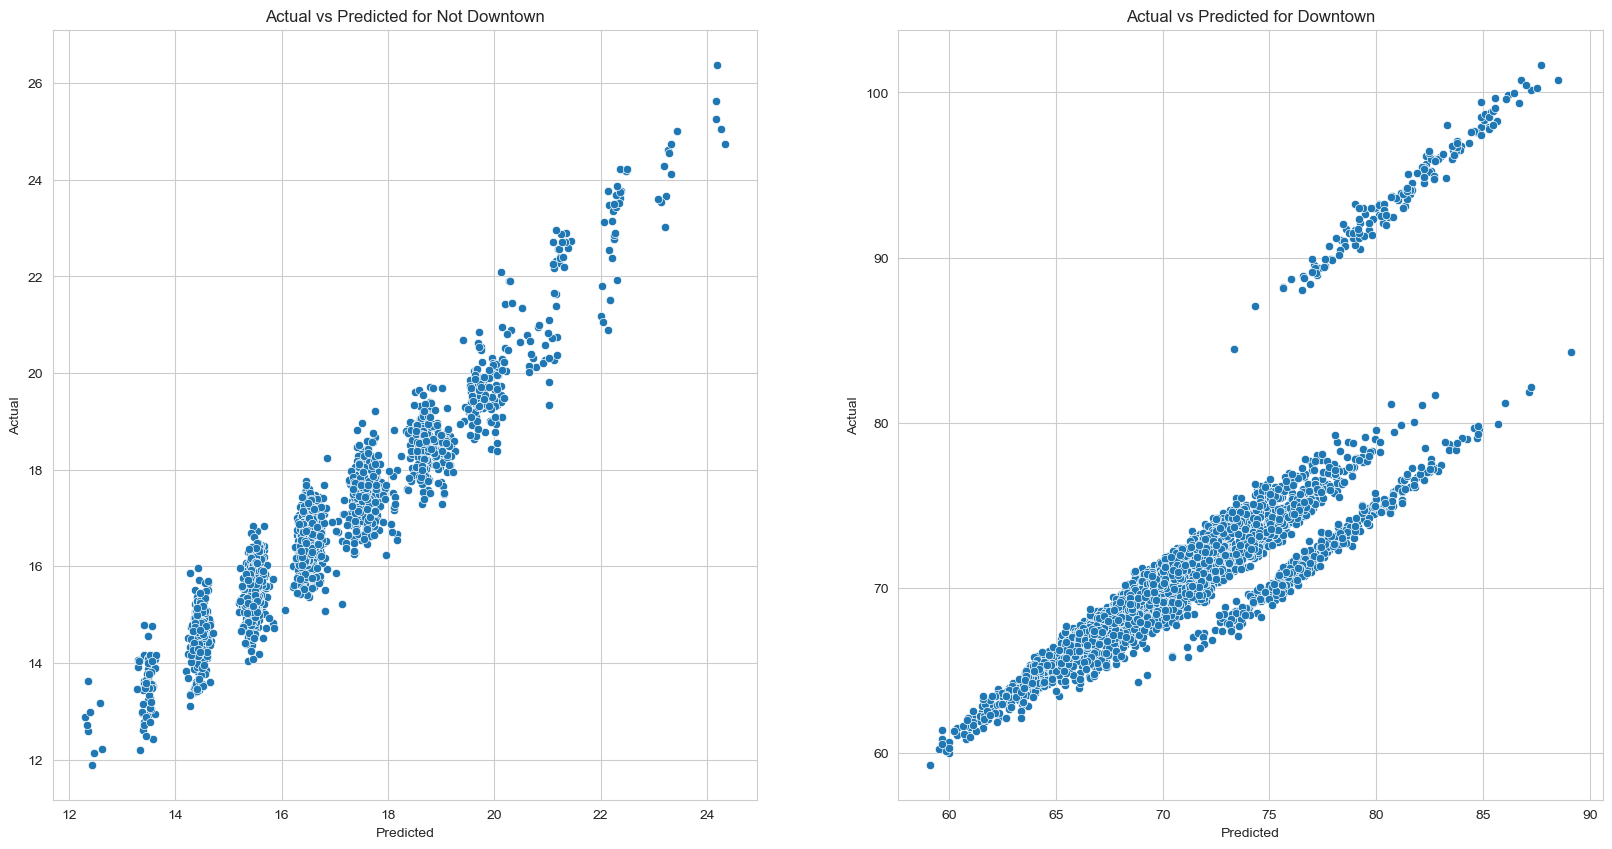

In [16]:
'''
Standard Linear Models for each group
'''

linear_downtown : LinearRegression = LinearRegression()
linear_notdowntown : LinearRegression = LinearRegression()


# === Downtown Model ===

y_obs_downtown = sample_downtown_hi['Withdraw']
x_obs_downtown = sample_downtown_hi.drop('Withdraw', axis=1)

x_downtown_scaled : np.ndarray = std_scaler.fit_transform(x_obs_downtown[numerical_covariates])
x_obs_downtown[numerical_covariates] = x_downtown_scaled

X_train_dt, X_test_dt, Y_train_dt, Y_test_dt = train_test_split(x_obs_downtown, y_obs_downtown, test_size=0.3, random_state=23)
linear_downtown.fit(X_train_dt, Y_train_dt)

# === Not Downtown Model ===

y_obs_n_downtown = sample_downtown_lo['Withdraw']
x_obs_n_downtown = sample_downtown_lo.drop('Withdraw', axis=1)

x_n_downtown_scaled : np.ndarray = std_scaler.fit_transform(x_obs_n_downtown[numerical_covariates])
x_obs_n_downtown[numerical_covariates] = x_n_downtown_scaled

X_train_ndt, X_test_ndt, Y_train_ndt, Y_test_ndt = train_test_split(x_obs_n_downtown, y_obs_n_downtown, test_size=0.3, random_state=23)
linear_notdowntown.fit(X_train_ndt, Y_train_ndt)

# === Analysis of Downtown Model ===

y_pred_dt : np.ndarray = linear_downtown.predict(X_test_dt)
residuals_dt : np.ndarray = Y_test_dt - y_pred_dt

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred_dt, y=residuals_dt, ax=axs[0])
axs[0].set_title('Downtown Model : Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals_dt, kde=True, ax=axs[1])
axs[1].set_title('Downtown Model : Distribution of Residuals')

plt.tight_layout()
plt.show()

# === Analysis of Not Downtown Model ===

y_pred_ndt : np.ndarray = linear_notdowntown.predict(X_test_ndt)
residuals_ndt : np.ndarray = Y_test_ndt - y_pred_ndt

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred_ndt, y=residuals_ndt, ax=axs[0])
axs[0].set_title('Not Downtown Model : Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals_ndt, kde=True, ax=axs[1])
axs[1].set_title('Not Downtown Model : Distribution of Residuals')

plt.tight_layout()
plt.show()

# === Actual vs Predicted Both Models ===

_, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x=y_pred_ndt, y=Y_test_ndt, ax=axs[0])
axs[0].set_title("Actual vs Predicted for Not Downtown")
axs[0].set_ylabel("Actual")
axs[0].set_xlabel("Predicted")


sns.scatterplot(x=y_pred_dt, y=Y_test_dt, ax=axs[1])
axs[1].set_title("Actual vs Predicted for Downtown")
axs[1].set_ylabel("Actual")
axs[1].set_xlabel("Predicted")

# === MSE Against Test Data ===

y_obs_test_dt : pd.DataFrame = raw_test[raw_test['Downtown'] == 1]['Withdraw']
y_obs_test_ndt : pd.DataFrame = raw_test[raw_test['Downtown'] == 0]['Withdraw']

x_obs_test : pd.DataFrame = raw_test.drop('Withdraw', axis=1)

x_scaled_test : np.ndarray = std_scaler.fit_transform(x_obs_test[numerical_covariates])
x_obs_test[numerical_covariates] = x_scaled_test

y_pred_test_dt = linear_downtown.predict(x_obs_test[x_obs_test['Downtown'] == 1].drop(columns=['Downtown']))
y_pred_test_ndt = linear_notdowntown.predict(x_obs_test[x_obs_test['Downtown'] == 0].drop(columns=['Downtown']))

mse_dt : float = mean_squared_error(y_pred_test_dt, y_obs_test_dt)
mse_ndt : float = mean_squared_error(y_pred_test_ndt, y_obs_test_ndt)

print(f"Downtown MSE vs Test Sample : {mse_dt}")
print(f"Downtown Model R2 Value : {r2_score(Y_test_dt, y_pred_dt)}")

print(f"Not Downtown MSE vs Test Sample : {mse_ndt}")
print(f"Not Downtown Model R2 Value : {r2_score(Y_test_ndt, y_pred_ndt)}")



### Interpretation of Standard Linear Models

We can see that the Non-downtown model performs quite well, suggesting that withdrawal behaviour in non-downtown areas is approximately linear and can be modelled by our covariates. It has a reasonably low MSE with the test sample of 2.08, and an R2 value of 0.92 when compared with the testing split of the data. However, the Downtown model appears to perform much weaker. It has a lower R2 value of around 0.71 and a much higher MSE against the test sample.

Looking at the residual plots (Histogram and Predicted vs Real), it is clear that the Not Downtown model's residuals are approximately normally distributed. The Downtown Model however shows that they are not. This suggests that our Downtown model may need some adjustments as there are clearly effects at play that our model is not capturing. The actual vs predicted plot suggests some non-linear behaviour may be present

## Modelling Non-Linear Effects in the downtown segment

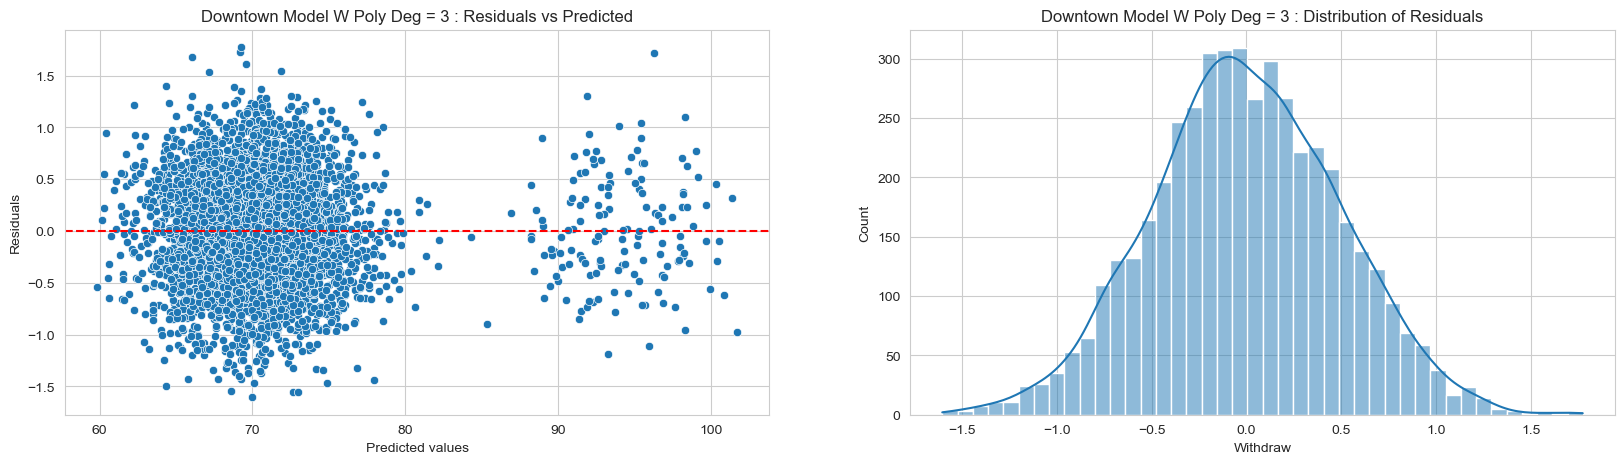

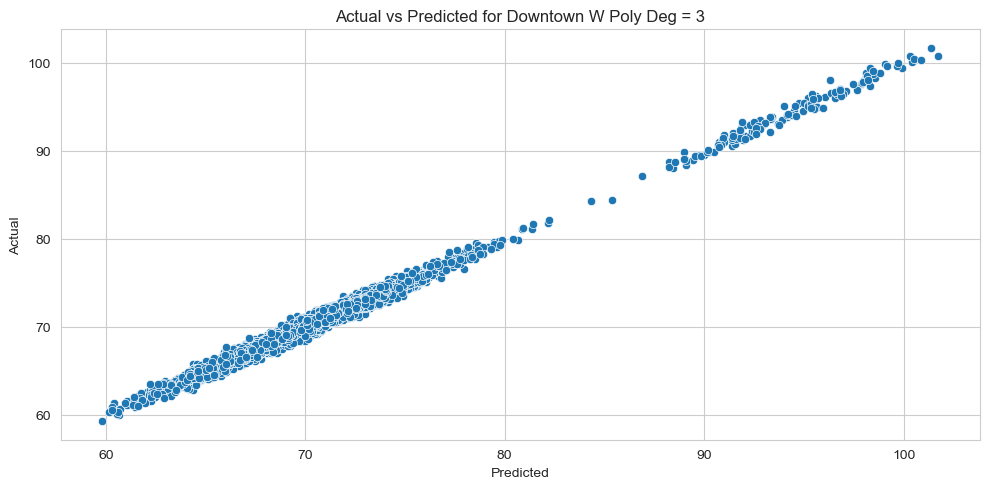

Downtown Poly MSE vs Test Sample : 2.083370453615856
Downtown Poly Model R2 Value : 0.9210420132140054


In [17]:
'''
Modelling Non-Linear Effects in the downtown segment
'''

# === Find optimal degree for interaction terms ===

possible_degress : list[int] = [d for d in range(1, 6)]
mses : list[float] = []
models : list[Pipeline] = []

for d in possible_degress :

    pipeline : Pipeline = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())
    pipeline.fit(X_train_dt, Y_train_dt)
    y_pred = pipeline.predict(X_test_dt)
    mse = mean_squared_error(Y_test_dt, y_pred)
    mses.append(mse)
    models.append(pipeline)

optimal_index : int = np.argmin(mses)
optimal_degree : int = possible_degress[optimal_index]
optimal_dt_model : Pipeline = models[optimal_index]

# === Assess the Optimal Interaction Downtown Model ===

y_pred_dt : np.ndarray = optimal_dt_model.predict(X_test_dt)
residuals_dt : np.ndarray = Y_test_dt - y_pred_dt

_, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(x=y_pred_dt, y=residuals_dt, ax=axs[0])
axs[0].set_title(f'Downtown Model W Poly Deg = {optimal_degree} : Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals_dt, kde=True, ax=axs[1])
axs[1].set_title(f'Downtown Model W Poly Deg = {optimal_degree} : Distribution of Residuals')

_, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(x=y_pred_dt, y=Y_test_dt, ax=axs)
axs.set_title(f"Actual vs Predicted for Downtown W Poly Deg = {optimal_degree}")
axs.set_ylabel("Actual")
axs.set_xlabel("Predicted")

plt.tight_layout()
plt.show()

mse_dt_poly : float = mean_squared_error(y_pred_test_dt, y_obs_test_dt)

print(f"Downtown Poly MSE vs Test Sample : {mse_ndt}")
print(f"Downtown Poly Model R2 Value : {r2_score(Y_test_ndt, y_pred_ndt)}")

### Discussion on Non-Linear Interaction Terms

Above it can be seen that including up to third order polynomial interaction terms has significantly improved the performance of the Downtown model. The MSE vs the test sample has come down from 14 to 2 whilst the R2 value has gone up to 0.92.

The inclusion of polynomial terms allows the model to capture more complex relationships between covariates. Since downtown is much more dense, with a lot more people, shops and ATMs it is likely that the factors influencing a person's withdrawal would be much more complicated, these interaction terms allow for this to be modelled. 

It is still clear that there are two distinct groups within the downtown segment itself, shown by the clustering in the residual vs predicted plot along with the groupings in the regression plot. Further analysis could involve splitting by another categorical variable. Perhaps the variable "Center" plays a large role in determining withdrawal behaviour for ATMs in the downtown area? However, for the purpose of this analysis we will not segment again.

### Combining Models

It is clear that both downtown and not downtown exhibit different behaviours. We want to attempt to combine these models into one. One possible solution could be to try a ridge model with the third order interaction terms. The ridge model should also help us avoid overfitting our model to the training data.

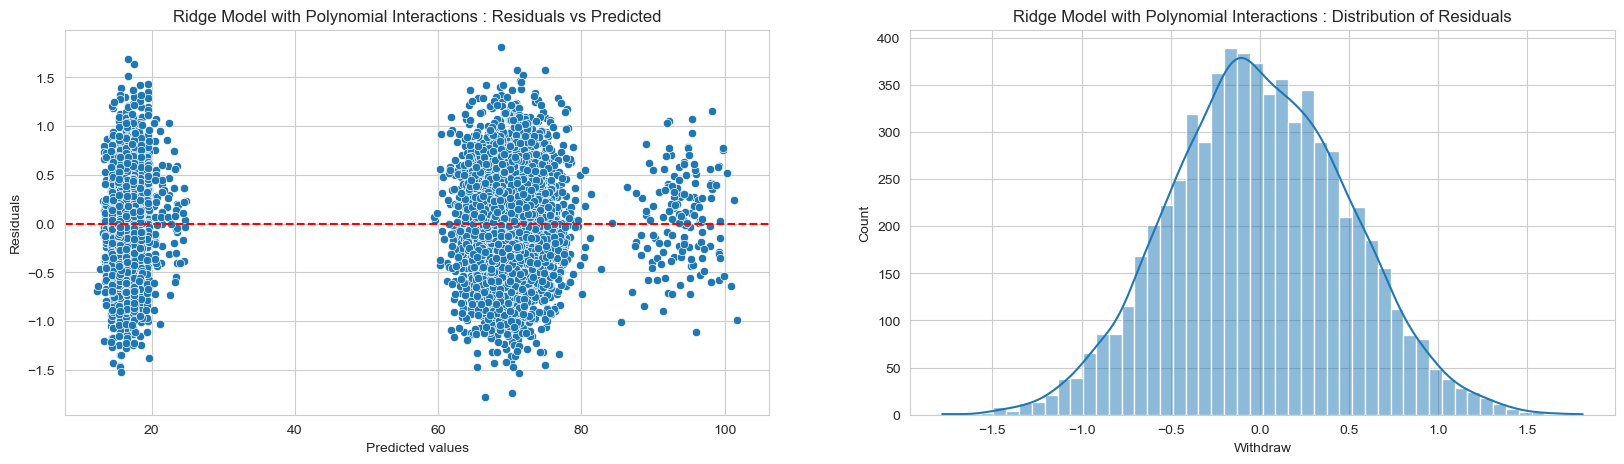

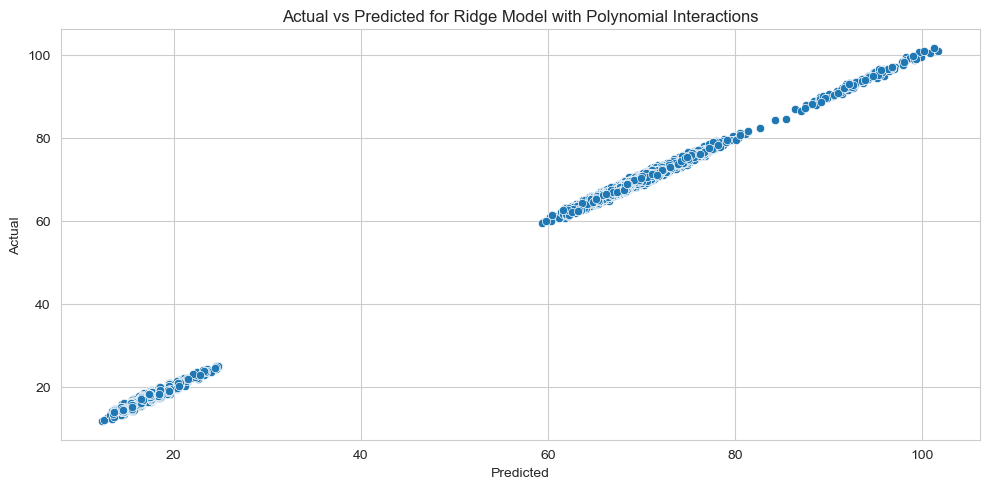

Ridge Poly MSE vs Test Sample : 0.37919133224885226
Ridge Poly R2 Value : 0.9994026806892621
Ridge Alpha : 0.01

=== Features ===

Feature : [Shops] - Weight : 15.181828383211007
Feature : [Shops Downtown] - Weight : 10.10640623260631
Feature : [Shops Downtown^2] - Weight : 10.106406229218875
Feature : [Shops Weekday Center] - Weight : -8.371547133287462
Feature : [Shops^2 Downtown] - Weight : 5.713202536492741
Feature : [Downtown^3] - Weight : 4.996872971771379
Feature : [Downtown] - Weight : 4.996872967025105
Feature : [Downtown^2] - Weight : 4.996872966717412
Feature : [Weekday^2 Center] - Weight : -4.936004747466196
Feature : [Weekday Center^2] - Weight : -4.9360047474661926
Feature : [Weekday Center] - Weight : -4.9360047471718245
Feature : [Center^3] - Weight : 4.2095187051483265
Feature : [Center^2] - Weight : 4.20951870483595
Feature : [Center] - Weight : 4.209518703961416
Feature : [Shops Downtown Center] - Weight : 3.5879349881093012
Feature : [Shops Center^2] - Weight : 2.49

In [18]:
'''
Ridge with Interaction
'''

# === Get Polynomial Features for entire dataset ===

poly_features : PolynomialFeatures = PolynomialFeatures(degree=optimal_degree, include_bias=False)
x_obs_poly : pd.DataFrame = poly_features.fit_transform(x_obs)
feature_names = poly_features.get_feature_names_out(input_features=x_obs.columns)

X_train_poly, X_test_poly, Y_train_poly, Y_test_poly = train_test_split(x_obs_poly, y_obs, test_size=0.3, random_state=23)

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge = Ridge(random_state=95)
ridge_cv = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_poly, Y_train_poly)

best_ridge_model = ridge_cv.best_estimator_

y_pred_poly = best_ridge_model.predict(X_test_poly)
coefficients = best_ridge_model.coef_


residuals_poly : np.ndarray = Y_test_poly - y_pred_poly

_, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(x=y_pred_poly, y=residuals_poly, ax=axs[0])
axs[0].set_title(f'Ridge Model with Polynomial Interactions : Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals_poly, kde=True, ax=axs[1])
axs[1].set_title(f'Ridge Model with Polynomial Interactions : Distribution of Residuals')

_, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(x=y_pred_poly, y=Y_test_poly, ax=axs)
axs.set_title(f"Actual vs Predicted for Ridge Model with Polynomial Interactions")
axs.set_ylabel("Actual")
axs.set_xlabel("Predicted")

plt.tight_layout()
plt.show()

x_test_sample_poly : pd.DataFrame = poly_features.fit_transform(x_test_sample)
y_test_pred_poly = best_ridge_model.predict(x_test_sample_poly)

mse_poly : float = mean_squared_error(y_test_sample, y_test_pred_poly)

print(f"Ridge Poly MSE vs Test Sample : {mse_poly}")
print(f"Ridge Poly R2 Value : {r2_score(y_test_sample, y_test_pred_poly)}")
print(f"Ridge Alpha : {best_ridge_model.get_params()['alpha']}")

# Get Features and sort by weights
feature_weights : list[tuple] = [fw for fw in zip(feature_names, coefficients)]
feature_weights = sorted(feature_weights, key=lambda x : np.abs(x[1]), reverse=True)

print("\n=== Features ===\n")
for feature in feature_weights :
    print(f"Feature : [{feature[0]}] - Weight : {feature[1]}")



In [19]:
'''
End of script - The part that prints the test error for markers
'''

print("\n === Error ===\n")
print(mse_poly)


 === Error ===

0.37919133224885226


### Discussion on Ridge with Interaction Terms

The above model shows a great improvement, having a MSE of 0.379 and an R2 value of 0.994. This model incorporated polynomial interactions terms for both downtown and not downtown groupings in the data. This allowed for more complex relationships to be captured, the results of which can be seen in the outputs.